In [1]:
import numpy as np
import os
import configparser

from keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD
from keras import models

import sys
sys.path.insert(0, './lib/')
from help_functions import *

#function to obtain data for training/testing (validation)
from extract_patches import get_data_training

Using TensorFlow backend.


## custom U-net Model

In [2]:
def unet(n_ch,patch_height,patch_width):
    inputs = layers.Input(shape=(n_ch,patch_height,patch_width))
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = layers.Dropout(0.2)(conv1)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    #
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = layers.Dropout(0.2)(conv2)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    #
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = layers.Dropout(0.2)(conv3)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = layers.concatenate([conv2,up1],axis=1)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv4 = layers.Dropout(0.2)(conv4)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    #
    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    up2 = layers.concatenate([conv1,up2], axis=1)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv5 = layers.Dropout(0.2)(conv5)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    #
    conv6 = layers.Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    conv6 = layers.core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = layers.core.Permute((2,1))(conv6)
    ############
    conv7 = layers.core.Activation('softmax')(conv6)

    model = models.Model(inputs=inputs, outputs=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [3]:
#for batch normalization
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = layers.Conv2D(filters=n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer= 'he_normal',
                     padding = 'same',data_format='channels_first')(input_tensor)
    
    if batchnorm ==True:
        x = layers.BatchNormalization()(x)
    
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters=n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer= 'he_normal',
                     padding = 'same',data_format='channels_first')(x)
    if batchnorm ==True:
        x = layers.BatchNormalization()(x)
    
    x = layers.Activation('relu')(x)
    return x
    

In [4]:
def unet_norm(n_ch,patch_height,patch_width):
    inputs = layers.Input(shape=(n_ch,patch_height,patch_width))
    conv1 = conv2d_block(inputs, n_filters= 32, kernel_size=3, batchnorm=True)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    #
    conv2 = conv2d_block(pool1, n_filters= 64, kernel_size=3, batchnorm=True)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    #
    conv3 = conv2d_block(pool2, n_filters= 128, kernel_size=3, batchnorm=True)
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = layers.concatenate([conv2,up1],axis=1)
    
    
    conv4 = conv2d_block(up1, n_filters= 64, kernel_size=3, batchnorm=True)
    
    
    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    up2 = layers.concatenate([conv1,up2], axis=1)
    conv5 = conv2d_block(up2, n_filters= 32, kernel_size=3, batchnorm=True)
    
    conv6 = layers.Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    
    conv6 = layers.core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = layers.core.Permute((2,1))(conv6)
    ############
    conv7 = layers.core.Activation('softmax')(conv6)

    model = models.Model(inputs=inputs, outputs=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

### Load Configuration

In [5]:
config = configparser.RawConfigParser()
config.read('configuration.txt')
#patch to the datasets
path_data = config.get('data paths', 'path_local')
#Experiment name
name_experiment = config.get('experiment name', 'name')
#training settings
num_epochs = int(config.get('training settings', 'num_epochs'))
batch_size = int(config.get('training settings', 'batch_size'))

In [6]:
print(name_experiment)

DRIVE_test_norm_190000


In [7]:
if os.path.isdir('./'+name_experiment) == False:
    os.mkdir('./'+name_experiment)
else:
    print('already exist the folder in this path : {}'.format('./'+name_experiment))

### Extract patch for training

In [8]:
patches_imgs_train, patches_masks_train = get_data_training(
    DRIVE_train_imgs_original = path_data + config.get('data paths', 'train_imgs_original'),
    DRIVE_train_groudTruth = path_data + config.get('data paths', 'train_groundTruth'),  #masks
    patch_height = int(config.get('data attributes', 'patch_height')),
    patch_width = int(config.get('data attributes', 'patch_width')),
    num_subimgs = int(config.get('training settings', 'num_subimgs')),
    inside_FOV = config.getboolean('training settings', 'inside_FOV'), #select the patches only inside the FOV  (default == True)
    save_path = name_experiment
)

already exist the folder in this path : DRIVE_test_norm_190000
number of subimages :  190000
[group images func] prev data shape :  (20, 3, 584, 565)
[group images func] after data shape :  (20, 584, 565, 3)
[group images func] first total image :  (584, 2825, 3)
[group images func] final total image :  (2920, 2825, 3)
data shape :  (2920, 2825, 3)
<PIL.Image.Image image mode=RGB size=2825x2920 at 0x7FA6692BC9E8>
file name :  ./DRIVE_test_norm_190000/imgs_train
[group images func] prev data shape :  (20, 1, 584, 565)
[group images func] after data shape :  (20, 584, 565, 1)
[group images func] first total image :  (584, 2825, 1)
[group images func] final total image :  (2920, 2825, 1)
data shape :  (2920, 2825, 1)
<PIL.Image.Image image mode=L size=2825x2920 at 0x7FA65C8D2320>
file name :  ./DRIVE_test_norm_190000/preprocessed
[get_data_training] preprocessed image shape :  (20, 1, 584, 565)
[get_data_training] preprocessed2 image shape :  (20, 1, 565, 565)

[get_data_training] train i

### Visualizing

[group images func] prev data shape :  (40, 1, 48, 48)
[group images func] after data shape :  (40, 48, 48, 1)
[group images func] first total image :  (48, 240, 1)
[group images func] final total image :  (432, 240, 1)
data shape :  (432, 240, 1)
<PIL.Image.Image image mode=L size=240x432 at 0x7FA65C8D2438>
file name :  ./DRIVE_test_norm_190000/sample_input_imgs
[group images func] prev data shape :  (40, 1, 48, 48)
[group images func] after data shape :  (40, 48, 48, 1)
[group images func] first total image :  (48, 240, 1)
[group images func] final total image :  (432, 240, 1)
data shape :  (432, 240, 1)
<PIL.Image.Image image mode=L size=240x432 at 0x7FA65C8D2390>
file name :  ./DRIVE_test_norm_190000/sample_input_masks


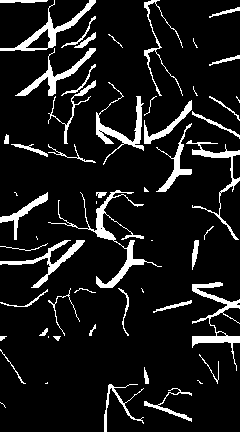

In [9]:
N_sample = min(patches_imgs_train.shape[0],40)
visualize(group_images(patches_imgs_train[0:N_sample,:,:,:],5),'./'+name_experiment+'/'+"sample_input_imgs")#.show()
visualize(group_images(patches_masks_train[0:N_sample,:,:,:],5),'./'+name_experiment+'/'+"sample_input_masks")#.show()

In [ ]:
### data generator test




In [10]:
n_ch = patches_imgs_train.shape[1]
patch_height = patches_imgs_train.shape[2]
patch_width = patches_imgs_train.shape[3]

model = unet_norm(n_ch, patch_height, patch_width)  #the U-net model
print ("Check: final output of the network:")
print (model.output_shape)

plot(model, to_file= './'+name_experiment+'/'+name_experiment + '_model.png')   #check how the model looks like
json_string = model.to_json()
open('./'+name_experiment+'/'+name_experiment +'_architecture.json', 'w').write(json_string)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 48, 48)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 48, 48)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 48, 48)   192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 48, 48)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

17546

In [11]:
print(int(config.get('training settings', 'num_subimgs')))

190000


### Training Session

In [12]:
'''
Keras provides a set of functions called callbacks: 
you can think of callbacks as events that will be triggered at certain training states. 
The callback we need for checkpointing is the ModelCheckpoint 
which provides all the features we need according to the checkpointing strategy we adopted in our example
'''

checkpointer = ModelCheckpoint(filepath='./'+name_experiment+'/best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased

print('[training session] before mask unet func patch mask shape : ',patches_masks_train.shape)
patches_masks_train = masks_Unet(patches_masks_train)  #reduce memory consumption
print('[training session] after mask unet func patch mask shape : ',patches_masks_train.shape)


history = model.fit(patches_imgs_train, patches_masks_train, epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.1, callbacks=[checkpointer])
model.save_weights('./'+name_experiment +'/last_weights.h5', overwrite=True)


[training session] before mask unet func patch mask shape :  (190000, 1, 48, 48)
[training session] after mask unet func patch mask shape :  (190000, 2304, 2)
Train on 171000 samples, validate on 19000 samples
Epoch 1/150
171000/171000 [==============================] - 325s 2ms/step - loss: 0.1777 - acc: 0.9409 - val_loss: 0.1185 - val_acc: 0.9559

Epoch 00001: val_loss improved from inf to 0.11854, saving model to ./DRIVE_test_norm_190000/best_weights.h5
Epoch 2/150
171000/171000 [==============================] - 325s 2ms/step - loss: 0.1251 - acc: 0.9527 - val_loss: 0.1331 - val_acc: 0.9506

Epoch 00002: val_loss did not improve from 0.11854
Epoch 3/150
171000/171000 [==============================] - 326s 2ms/step - loss: 0.1193 - acc: 0.9547 - val_loss: 0.1102 - val_acc: 0.9585

Epoch 00003: val_loss improved from 0.11854 to 0.11015, saving model to ./DRIVE_test_norm_190000/best_weights.h5
Epoch 4/150
171000/171000 [==============================] - 327s 2ms/step - loss: 0.1155 -


Epoch 00039: val_loss did not improve from 0.10013
Epoch 40/150
171000/171000 [==============================] - 324s 2ms/step - loss: 0.0914 - acc: 0.9641 - val_loss: 0.1083 - val_acc: 0.9590

Epoch 00040: val_loss did not improve from 0.10013
Epoch 41/150
171000/171000 [==============================] - 324s 2ms/step - loss: 0.0911 - acc: 0.9642 - val_loss: 0.1068 - val_acc: 0.9595

Epoch 00041: val_loss did not improve from 0.10013
Epoch 42/150
171000/171000 [==============================] - 324s 2ms/step - loss: 0.0907 - acc: 0.9644 - val_loss: 0.1066 - val_acc: 0.9596

Epoch 00042: val_loss did not improve from 0.10013
Epoch 43/150
171000/171000 [==============================] - 324s 2ms/step - loss: 0.0905 - acc: 0.9644 - val_loss: 0.1037 - val_acc: 0.9605

Epoch 00043: val_loss did not improve from 0.10013
Epoch 44/150
171000/171000 [==============================] - 324s 2ms/step - loss: 0.0902 - acc: 0.9645 - val_loss: 0.1033 - val_acc: 0.9607

Epoch 00044: val_loss did not

171000/171000 [==============================] - 324s 2ms/step - loss: 0.0809 - acc: 0.9677 - val_loss: 0.1109 - val_acc: 0.9590

Epoch 00082: val_loss did not improve from 0.10013
Epoch 83/150
171000/171000 [==============================] - 323s 2ms/step - loss: 0.0807 - acc: 0.9677 - val_loss: 0.1086 - val_acc: 0.9602

Epoch 00083: val_loss did not improve from 0.10013
Epoch 84/150
171000/171000 [==============================] - 323s 2ms/step - loss: 0.0805 - acc: 0.9678 - val_loss: 0.1085 - val_acc: 0.9608

Epoch 00084: val_loss did not improve from 0.10013
Epoch 85/150
171000/171000 [==============================] - 323s 2ms/step - loss: 0.0803 - acc: 0.9679 - val_loss: 0.1096 - val_acc: 0.9604

Epoch 00085: val_loss did not improve from 0.10013
Epoch 86/150
171000/171000 [==============================] - 324s 2ms/step - loss: 0.0801 - acc: 0.9679 - val_loss: 0.1090 - val_acc: 0.9601

Epoch 00086: val_loss did not improve from 0.10013
Epoch 87/150
171000/171000 [===============

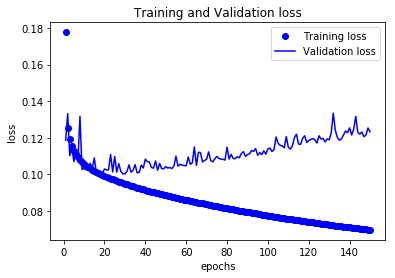

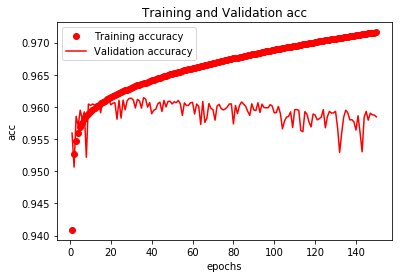

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss= history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1,len(acc) +1)

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.legend()
plt.savefig(name_experiment+"/training_loss_result.png")
plt.figure()

plt.plot(epochs, acc, 'ro', label = "Training accuracy")
plt.plot(epochs, val_acc, 'r', label = "Validation accuracy")
plt.title("Training and Validation acc")
plt.xlabel("epochs")
plt.ylabel('acc')
plt.legend()


plt.savefig(name_experiment+"/training_acc_result.png")
plt.show()